# PyTorch Tricks

## Quick build

There're two ways to build a neural netword.

The first way we have seen before:

In [0]:
import torch
import torch.nn as nn

class Net(nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)
        self.predict = torch.nn.Linear(n_hidden, n_output)

    def forward(self, x):
        x = F.relu(self.hidden(x))
        x = self.predict(x)
        return x
  

In [0]:
net1 = Net(1, 10, 1)

Another way:

In [0]:
net2 = nn.Sequential(
    nn.Linear(1, 10) ,
    nn.ReLU(),
    nn.Linear(10, 1)
)

In [193]:
print('net1:\n', net1)
print('\nnet2:\n', net2)

net1:
 Net(
  (hidden): Linear(in_features=1, out_features=10, bias=True)
  (predict): Linear(in_features=10, out_features=1, bias=True)
)

net2:
 Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=1, bias=True)
)


## Save trained models

In [0]:
torch.manual_seed(1)

# Mock data
x = torch.unsqueeze(torch.linspace(-1, 1, 100), dim=1) # tensor, shape=(100, 1)
y = x.pow(2) + 0.2 * torch.rand(x.size()) # tensor, shape=(100, 1)

We use the `net2` defined above.

In [0]:
# Train

import torch.optim as optim

optimizer = optim.SGD(net2.parameters(), lr=0.2)
loss_func = nn.MSELoss()

for t in range(2000):
    optimizer.zero_grad()
    prediction = net2(x)
    loss = loss_func(prediction, y)
    loss.backward()
    optimizer.step()

Two ways to save:

- Save the WHOLE network

In [0]:
torch.save(net2, 'net2.pkl')

- Only save the parameters of the network (quick, less memory)

In [0]:
torch.save(net2.state_dict(), 'net2_params.pkl')

### Load trained network

Just like saving, there're two ways to load:

- Load the whole network

In [0]:
net3 = torch.load('net2.pkl')
prediction = net3(x)

- Load only the parameters

In [0]:
net4 = nn.Sequential(
    nn.Linear(1, 10),
    nn.ReLU(),
    nn.Linear(10, 1)
)

# load saved params and apply to the new model
net4.load_state_dict(torch.load('net2_params.pkl')) 
prediction = net4(x)

Visualize predictions of `net2`, `net3`, `net4`:

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

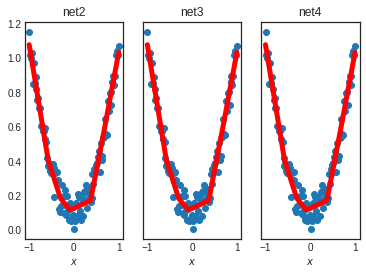

In [201]:
fig, axes = plt.subplots(1, 3, sharey=True)

models = {'net2': net2, 
          'net3': net3, 
          'net4': net4}

for i, model in enumerate(models.items()):
    ax = axes[i]
    ax.axis('equal')
    ax.set(xlim=(-1, 1), ylim=(-0.5, 1.5),
        xlabel='$x$', title=model[0])
    ax.scatter(x.data.numpy(), y.data.numpy())
    ax.plot(x.numpy(), model[1](x).data.numpy(), 'r-', lw=5)
    ax.axis('tight')


## (Mini-)Batch training

`DataLoader` can help us to iterate data efficiently.

In [0]:
import torch.utils.data as Data

In [203]:
torch.manual_seed(1)

BATCH_SIZE = 8

x = torch.linspace(1, 10, 10)
y = torch.linspace(10, 1, 10)

# Create dataset
torch_dataset = Data.TensorDataset(x, y)

# Put dataset into DataLoader
loader = Data.DataLoader(
    dataset=torch_dataset, # torch TensorDataset format
    batch_size=BATCH_SIZE, # mini batch size
    shuffle=True, 
    num_workers=2 # multi-thread
)

for epoch in range(4): # train WHOLE dataset for 3 times
    for step, (batch_x, batch_y) in enumerate(loader):
        # At each step the loader will use a mini-batch of data for training

        # Train our model

        # print some statistics
        print('Epoch: ', epoch, '| Step: ', step, '| batch x: ',
              batch_x.numpy(), '| batch y: ', batch_y.numpy())

Epoch:  0 | Step:  0 | batch x:  [ 5.  7. 10.  3.  4.  2.  1.  8.] | batch y:  [ 6.  4.  1.  8.  7.  9. 10.  3.]
Epoch:  0 | Step:  1 | batch x:  [9. 6.] | batch y:  [2. 5.]
Epoch:  1 | Step:  0 | batch x:  [ 4.  6.  7. 10.  8.  5.  3.  2.] | batch y:  [7. 5. 4. 1. 3. 6. 8. 9.]
Epoch:  1 | Step:  1 | batch x:  [1. 9.] | batch y:  [10.  2.]
Epoch:  2 | Step:  0 | batch x:  [ 4.  2.  5.  6. 10.  3.  9.  1.] | batch y:  [ 7.  9.  6.  5.  1.  8.  2. 10.]
Epoch:  2 | Step:  1 | batch x:  [8. 7.] | batch y:  [3. 4.]
Epoch:  3 | Step:  0 | batch x:  [ 4. 10.  9.  8.  7.  6.  1.  2.] | batch y:  [ 7.  1.  2.  3.  4.  5. 10.  9.]
Epoch:  3 | Step:  1 | batch x:  [5. 3.] | batch y:  [6. 8.]


## Speed up training

- Stochastic Gradient Descent (SGD)
- Momentum
- AdaGrad
- RMSProp
- Adam




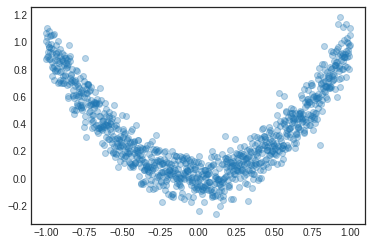

In [204]:
import torch.nn.functional as F

LR = 0.01
BATCH_SIZE = 32
EPOCH = 12

# Mock dataset
x = torch.unsqueeze(torch.linspace(-1, 1, 1000), dim=1)
y = x.pow(2) + 0.1*torch.normal(torch.zeros(*x.size()))

# plot dataset
plt.scatter(x.numpy(), y.numpy(), alpha=0.3)

torch_dataset = Data.TensorDataset(x, y)
loader = Data.DataLoader(dataset=torch_dataset, batch_size=BATCH_SIZE, 
                         shuffle=True, num_workers=2)

In order to compare the optimizers, we will build a neural network with same structure for each optimizer.

In [0]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.hidden = nn.Linear(1, 20) # hidden layer
        self.predict = nn.Linear(20, 1) # output layer

    def forward(self, x):
        x = F.relu(self.hidden(x))
        x = self.predict(x)
        return x
        

In [0]:
net_SGD = Net()
net_Momentum = Net()
net_RMSprop = Net()
net_Adam = Net()
nets = [net_SGD, net_Momentum, net_RMSprop, net_Adam]

In [0]:
optim_SGD = optim.SGD(net_SGD.parameters(), lr=LR)
optim_Momentum = optim.SGD(net_Momentum.parameters(), lr=LR, momentum=0.8)
optim_RMSprop = optim.RMSprop(net_RMSprop.parameters(), lr=LR, alpha=0.9)
optim_Adam = optim.Adam(net_Adam.parameters(), lr=LR, betas=(0.9, 0.99))
optimizers = [optim_SGD, optim_Momentum, optim_RMSprop, optim_Adam]

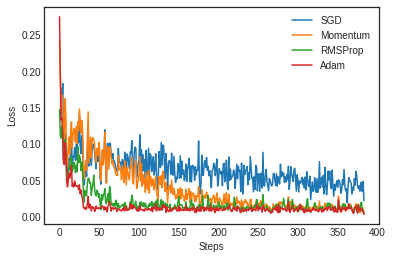

In [208]:
# loss func
loss_func = nn.MSELoss()
losses_history = [[], [], [], []]

# Train and record loss

for epoch in range(EPOCH):
    # print('Epoch:', epoch)

    for step, (b_x, b_y) in enumerate(loader):
        for net, optimizer, loss_history in zip(nets, optimizers, 
                                                losses_history):
            optimizer.zero_grad()

            output = net(b_x)
            loss = loss_func(output, b_y)
            loss.backward()
            optimizer.step()

            loss_history.append(loss.data.numpy())


# Plot loss
optimizer_names = ['SGD', 'Momentum', 'RMSProp','Adam']
plt.figure()
plt.xlabel('Steps')
plt.ylabel('Loss')
for i, optim_name in enumerate(optimizer_names):
    plt.plot(range(len(losses_history[i])), losses_history[i], label=optim_name)
plt.legend()